# pysat demo using data from ACE SIS

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

import pysat
import pysatSpaceWeather

In [2]:
# Set data directory if user hasn't already set one
print(f"old: {pysat.params['data_dirs']}")
if len(pysat.params['data_dirs']) == 0 or pysat.params['data_dirs'] == ['.']:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '/home/jovyan/scratch_space/.pysat/'
else:
    print('pysat directory has been set previously. Leaving unchanged.')

print(f"new: {pysat.params['data_dirs']}")

old: ['/home/jovyan/scratch_space/.pysat']
pysat directory has been set previously. Leaving unchanged.
new: ['/home/jovyan/scratch_space/.pysat']


In [3]:
pysat.params

pysat._params.Parameters(path=r"/home/jovyan/.pysat")

In [4]:
# Register instruments with pysat. Only needed once per install.
pysat.utils.registry.register_by_module(pysatSpaceWeather.instruments)

In [5]:
# Instantiate a pysat Instrument that will use support in 
# pysatSpaceWeather for ACE Space Weather data.
ace = pysat.Instrument('ace', 'sis', tag='historic')

In [6]:
# Learn about ACE SIS dataset.
help(ace.inst_module)

Help on module pysatSpaceWeather.instruments.ace_sis in pysatSpaceWeather.instruments:

NAME
    pysatSpaceWeather.instruments.ace_sis - Supports ACE Solar Isotope Spectrometer data.

DESCRIPTION
    Properties
    ----------
    platform
        'ace' Advanced Composition Explorer
    name
        'sis' Solar Isotope Spectrometer
    tag
        - 'realtime' Real-time data from the Space Weather Prediction Center (SWPC)
        - 'historic' Historic data from the SWPC
    inst_id
        - ''
    
    Note
    ----
    This is not the ACE scientific data set, which will be available at pysatNASA
    
    Examples
    --------
    The real-time data is stored by generation date, where each file contains the
    data for the current day.  If you leave download dates empty, though, it will
    grab today's file three times and assign dates from yesterday, today, and
    tomorrow.
    ::
    
        sis = pysat.Instrument('ace', 'sis', tag='realtime')
        sis.download(start=sis.today

In [7]:
def calc_ratio(inst):
    """Calculate ratio of 30 MeV / 10 MeV flux.
    
    Adds ratio in-place via label `ratio_30_10`.
    
    Parameters
    ----------
    inst : pysat.Instrument
    
    """
    
    # Calculate ratio.
    var1 = 'int_pflux_30MeV'
    var2 = 'int_pflux_10MeV'
    inst['ratio_30_10'] = inst[var1] / inst[var2]
    
    # Define then assign metadata. Style of assignment a.k.a `inst.meta.labels...`
    # is used by pysat developers to ensure code works in the most general case. Note
    # that users, and not values in written files, are in control of the string values 
    # used to identify metadata. For this Jupyter notebook, since we are in full control of the
    # pysat.Instrument object this code is applied to, 'units', 'name', 'desc'
    # could be used instead.
    desc = 'Ratio of integrated proton flux, 30 MeV / 10 MeV.'
    name = 'Ratio of 30 MeV / 10 MeV Proton Flux'
    meta = {inst.meta.labels.units: '', 
            inst.meta.labels.name: name,
            inst.meta.labels.desc: desc,
            inst.meta.labels.min_val: 0., 
            inst.meta.labels.max_val: np.inf, 
            inst.meta.labels.fill_val: np.nan}
    inst.meta['ratio_30_10'] = meta
    
    return

# Assign `calc_ratio` to `ace` which is applied automatically as data loaded.
ace.custom_attach(calc_ratio)

In [8]:
# Download data for July, 2021. We shouldn't need to do this
# ace.download(dt.datetime(2021, 7, 1), dt.datetime(2021, 7, 31))

In [9]:
# Load all data which applies any custom functions, in this case
# `calc_ratio`. Any analysis functions that interact with `ace`
# will have access to any custom user generated variables.
ace.load(use_header=True)

/tmp/ipykernel_444/704821899.py:4: DeprecationWarning: Meta now contains a class for global metadata (MetaHeader). Allowing attachment of global attributes to Instrument through `use_header=False` will be Deprecated in pysat 3.3.0+. Remove `use_header` kwarg (now same as `use_header=True`) to stop this warning.
  ace.load(use_header=True)


In [10]:
# Learn about ACE Instrument object.
print(ace)

pysat Instrument object
-----------------------
Platform: 'ace'
Name: 'sis'
Tag: 'historic'
Instrument id: ''

Data Processing
---------------
Cleaning Level: 'clean'
Data Padding: None
Custom Functions: 1 applied
    0: <function calc_ratio at 0x7f3ff5123760>

Local File Statistics
---------------------
Number of files: 31
Date Range: 01 July 2021 --- 31 July 2021

Loaded Data Statistics
----------------------
Date: 01 July 2021
DOY: 182
Time range: 01 July 2021 00:00:00 --- 31 July 2021 23:55:00
Number of Times: 8255
Number of variables: 7

Variable Names:
jd              sec             status_10       
                      ...                       
status_30       int_pflux_30MeV ratio_30_10     

pysat Meta object
-----------------
Tracking 7 metadata values
Metadata for 7 standard variables
Metadata for 0 global attributes



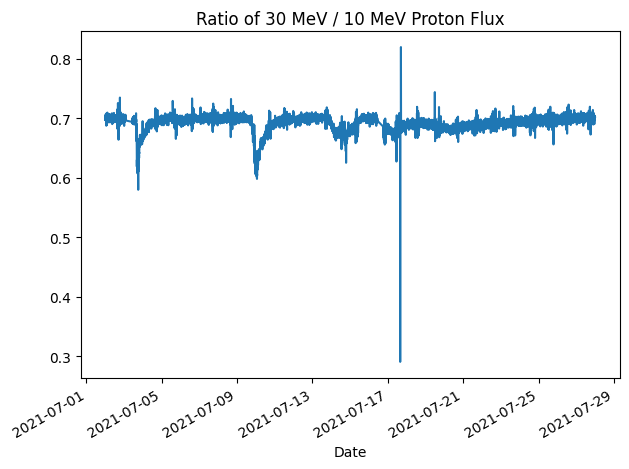

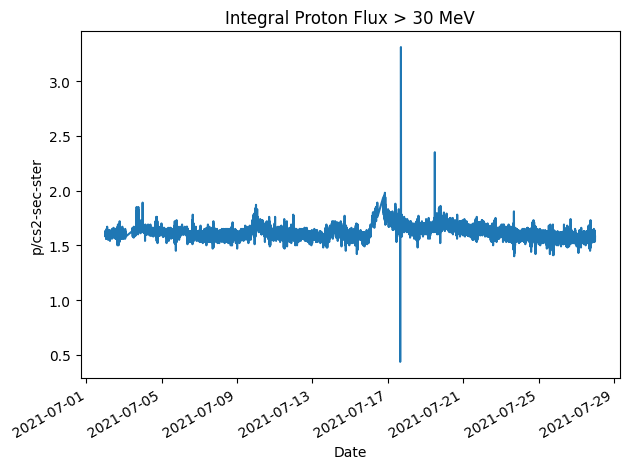

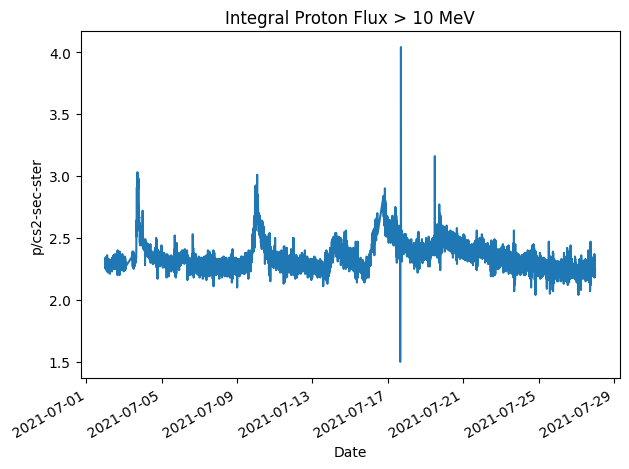

In [11]:
# Make plot of flux ratio and direct integrated fluxes for July, 2021.
sdate = dt.datetime(2021, 7, 2)
edate = dt.datetime(2021, 7, 28)
variables = ['ratio_30_10', 'int_pflux_30MeV', 'int_pflux_10MeV']
for var in variables:
    plt.figure()
    units = ace.meta[var, ace.meta.labels.units]
    title = ace.meta[var, ace.meta.labels.name]

    ace[sdate:edate, var].plot(title=title, ylabel=units, 
                               xlabel='Date')
    plt.tight_layout()
    plt.savefig(''.join([var, '_example.jpg']))
